# Data Splitting, Preprocessing and Feature Enginnering

Dataset:
  - Multiple time series: stocks, not iid
  - Predict target: price movement index 60 seconds later in the last 10 mins (Prediction Horizon is 60 seconds)
  - Split & Autoregressive features: Time series split by date_id:
    1. The dataset have grouped structure, is time series, and not iid
    2. Structure: date_id --> seconds in bucket (always 55 values for each day) --> stock_id (191-200 stocks in each time bucket)
    3. To follow real-world and competetion setting, we should make sure that:
       - For each record, only previous day target information (55 time buckets for each stock) will be revealed.
       - That means we cannot create inproper lags: e.g., lag within the same day
       - Also means that we should splited based on date_id & time series
       - And same stock on same day will have the same set of lagged target data
       - This is because it's possible that the synthetic index used in the target won't be calculated until the end of the day.
   - Method: python extension for grouped time series split
   - Note: in this case, the training & validation date will be continuous, but there will be time gap between the training and testing set! Though that might affect our model performance, it might be how the real-world & competition setting goes, I suggest to keep this. For this reason, I will also not create lagged feature for columns other than the target.

We will first construct auto-regressive target data for previous 1 day as stated, then perform time series splits based on date_id.

In [1]:
import gc
import os
import time
import warnings
import joblib

from itertools import combinations
from warnings import simplefilter

## Add Lagged Data

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit,
    plot_splits,
    print_cv_info,
    print_split_info,
)

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)

warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

data = pd.read_csv('../data/raw_kaggle/train.csv')

identifier_cols = ['time_id', 'row_id']
features = ['stock_id', 'seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 
            'reference_price', 'matched_size', 'far_price', 'near_price', 
            'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap',]
date_col, target_col = 'date_id', 'target'
lagged_cols = [f'lagged_target_1d_{i}' for i in range(0, 541, 10)]
cols = identifier_cols + [date_col] + features + lagged_cols + [target_col]

In [3]:
# Construct lagged features
df_lagged = data[['stock_id', 'date_id', 'seconds_in_bucket', 'target']].sort_values(by=['stock_id', 'date_id'])
df_pivot = df_lagged.pivot(index=['stock_id', 'date_id'], columns='seconds_in_bucket', values='target').reset_index()

stock_list = data[['stock_id']].drop_duplicates().sort_values(by='stock_id').reset_index(drop=True)
date_list =  data[['date_id']].drop_duplicates().sort_values(by='date_id').reset_index(drop=True)
df_expanded = pd.merge(stock_list, date_list, how='cross')
df_expanded = pd.merge(df_expanded, df_pivot, how='left', on=['stock_id', 'date_id'])

for i in range(0, 541, 10):
    df_expanded = df_expanded.rename(columns={i: f'lagged_target_1d_{i}'})

df_lagged = df_expanded.copy()

for i in range(0, 541, 10):
    df_lagged[f'lagged_target_1d_{i}'] = df_lagged.groupby('stock_id')[f'lagged_target_1d_{i}'].shift()

data_new = data.merge(df_lagged, how='left', on=['stock_id', 'date_id'])[cols]

### Data Description After Adding Lagged Data

At this stage, we have 72 columns and 5237980 rows:
- 1 target column
- 2 identifier columns (time_id, row_id): will be saved and dropped later, not entering model
- 3 id columns (stock_id, date_id, stock_id): date_id will also be dropped after spliting data
- 55 of the columns are lagged data
- 11 original market features

In [4]:
display(data_new.head())
print(data_new.shape)

,time_id,row_id,date_id,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,lagged_target_1d_0,lagged_target_1d_10,lagged_target_1d_20,lagged_target_1d_30,lagged_target_1d_40,lagged_target_1d_50,lagged_target_1d_60,lagged_target_1d_70,lagged_target_1d_80,lagged_target_1d_90,lagged_target_1d_100,lagged_target_1d_110,lagged_target_1d_120,lagged_target_1d_130,lagged_target_1d_140,lagged_target_1d_150,lagged_target_1d_160,lagged_target_1d_170,lagged_target_1d_180,lagged_target_1d_190,lagged_target_1d_200,lagged_target_1d_210,lagged_target_1d_220,lagged_target_1d_230,lagged_target_1d_240,lagged_target_1d_250,lagged_target_1d_260,lagged_target_1d_270,lagged_target_1d_280,lagged_target_1d_290,lagged_target_1d_300,lagged_target_1d_310,lagged_target_1d_320,lagged_target_1d_330,lagged_target_1d_340,lagged_target_1d_350,lagged_target_1d_360,lagged_target_1d_370,lagged_target_1d_380,lagged_target_1d_390,lagged_target_1d_400,lagged_target_1d_410,lagged_target_1d_420,lagged_target_1d_430,lagged_target_1d_440,lagged_target_1d_450,lagged_target_1d_460,lagged_target_1d_470,lagged_target_1d_480,lagged_target_1d_490,lagged_target_1d_500,lagged_target_1d_510,lagged_target_1d_520,lagged_target_1d_530,lagged_target_1d_540,target
0,0,0_0_0,0,0,0,3180602.6900,1,0.9998,13380276.6400,NaN,NaN,0.9998,60651.5000,1.0000,8493.0300,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.0297
1,0,0_0_1,0,1,0,166603.9100,-1,0.9999,1642214.2500,NaN,NaN,0.9999,3233.0400,1.0007,20605.0900,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.5200
2,0,0_0_2,0,2,0,302879.8700,-1,0.9996,1819368.0300,NaN,NaN,0.9994,37956.0000,1.0003,18995.0000,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.3900
3,0,0_0_3,0,3,0,11917682.2700,-1,1.0002,18389745.6200,NaN,NaN,1.0000,2324.9000,1.0002,479032.4000,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.0102
4,0,0_0_4,0,4,0,447549.9600,-1,0.9995,17860614.9500,NaN,NaN,0.9994,16485.5400,1.0000,434.1000,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.3498


(5237980, 72)


## Feature Engineering: Construct New Features

In [5]:
def imbalance_features(df):
    # Define lists of price and size-related column names
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
    
    # V1 features
    # Calculate various features using Pandas eval function
    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
    df["size_imbalance"] = df.eval("bid_size / ask_size")
    
    # Create features for pairwise price imbalances
    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")
    
    # V2 features
    # Calculate additional features   
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df['price_pressure'] = df['imbalance_size'] * df['price_spread']
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])

    # Calculate various statistical aggregation features
    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)

    return df.replace([np.inf, -np.inf], np.nan)

def other_features(df):
    df["dow"] = df["date_id"] % 5  # Day of the week
    df["seconds"] = df["seconds_in_bucket"] % 60  
    df["minute"] = df["seconds_in_bucket"] // 60  
    return df

def generate_all_features(df):
    # Select relevant columns for feature generation
    cols = [c for c in df.columns if c not in ["row_id", "time_id", "target"]]
    df = df[cols]
    
    # Generate imbalance features
    df = imbalance_features(df)
    # Generate time and stock-related features
    df = other_features(df)
    gc.collect()  # Perform garbage collection to free up memory
    
    # Select and return the generated features
    feature_name = [i for i in df.columns if i not in ["row_id", "target", "time_id", "date_id"]]
    
    return df[feature_name]

## Memeory Optimization

In this section, we optimized the memory usage for int columns. The memory usage can be reduced to half after the optimization.

In [6]:
def reduce_memory_usage(df):
    print("Memory Usage Before Optimization:")
    print(df.memory_usage(deep=True).sum() / (1024 ** 2), "MB")

    # Iterate through each column in the DataFrame
    for col in df.columns:
        col_type = df[col].dtype

        # Check if the column's data type is not 'object' (i.e., numeric)
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            # Check if the column's data type is an integer
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                # Check if the column's data type is a float
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)
                    
    # Display the memory usage after optimization
    print("\nMemory Usage After Optimization:")
    print(df.memory_usage(deep=True).sum() / (1024 ** 2), "MB")
    return df

## Split Test Data

After running the model, I found the single fold parameter searching time for XGB on GPU is more than 9 hours (for each set of parameter, the fitting round is more than 2000). For reduced features, the program ran out of memory for single fold even with no paramter tuning. There is no way to solve the memory error with limited resources if I still want to compare performance using different models. Therefore, I am cutting the dataset into 20% of the original size by date. It will still have 1M+ data in this case.

In [7]:
# Prepare data
data_new = data_new[data_new[date_col]<=120]
X = data_new.drop(columns=[target_col])
y = data_new[target_col]
groups = data_new[date_col]

In [8]:
print('Data Shape:', X.shape, y.shape)
display(X.head(3))

Data Shape: (1294810, 71) (1294810,)


,time_id,row_id,date_id,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,lagged_target_1d_0,lagged_target_1d_10,lagged_target_1d_20,lagged_target_1d_30,lagged_target_1d_40,lagged_target_1d_50,lagged_target_1d_60,lagged_target_1d_70,lagged_target_1d_80,lagged_target_1d_90,lagged_target_1d_100,lagged_target_1d_110,lagged_target_1d_120,lagged_target_1d_130,lagged_target_1d_140,lagged_target_1d_150,lagged_target_1d_160,lagged_target_1d_170,lagged_target_1d_180,lagged_target_1d_190,lagged_target_1d_200,lagged_target_1d_210,lagged_target_1d_220,lagged_target_1d_230,lagged_target_1d_240,lagged_target_1d_250,lagged_target_1d_260,lagged_target_1d_270,lagged_target_1d_280,lagged_target_1d_290,lagged_target_1d_300,lagged_target_1d_310,lagged_target_1d_320,lagged_target_1d_330,lagged_target_1d_340,lagged_target_1d_350,lagged_target_1d_360,lagged_target_1d_370,lagged_target_1d_380,lagged_target_1d_390,lagged_target_1d_400,lagged_target_1d_410,lagged_target_1d_420,lagged_target_1d_430,lagged_target_1d_440,lagged_target_1d_450,lagged_target_1d_460,lagged_target_1d_470,lagged_target_1d_480,lagged_target_1d_490,lagged_target_1d_500,lagged_target_1d_510,lagged_target_1d_520,lagged_target_1d_530,lagged_target_1d_540
0,0,0_0_0,0,0,0,3180602.6900,1,0.9998,13380276.6400,NaN,NaN,0.9998,60651.5000,1.0000,8493.0300,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0_0_1,0,1,0,166603.9100,-1,0.9999,1642214.2500,NaN,NaN,0.9999,3233.0400,1.0007,20605.0900,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0_0_2,0,2,0,302879.8700,-1,0.9996,1819368.0300,NaN,NaN,0.9994,37956.0000,1.0003,18995.0000,1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Other index: [      0       1       2 ... 1034767 1034768 1034769] TEST index: [1034770 1034771 1034772 ... 1294807 1294808 1294809]


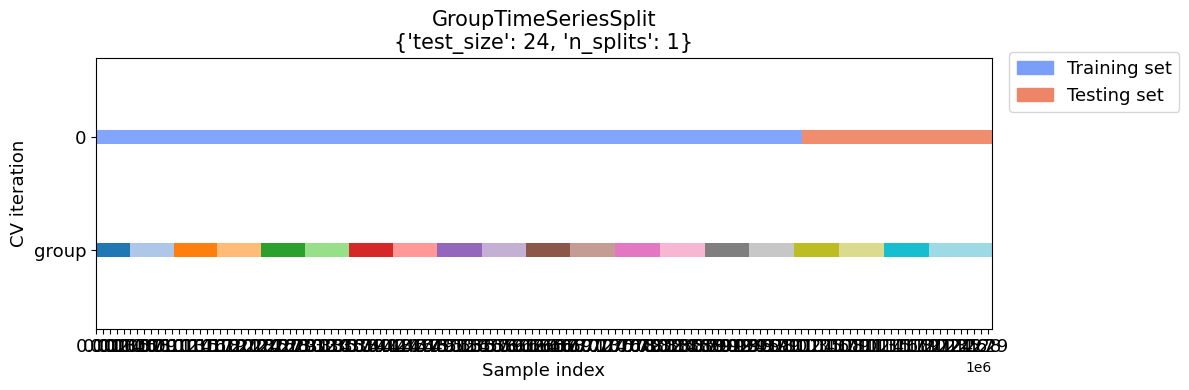

Train indices: [      0       1       2 ... 1034767 1034768 1034769]
Test indices: [1034770 1034771 1034772 ... 1294807 1294808 1294809]
Train length: 1034770
Test length: 260040
Train groups: [ 0  0  0 ... 96 96 96]
Test groups: [ 97  97  97 ... 120 120 120]
Train group size: 97
Test group size: 24
Train group months: [      0       1       2 ... 1034767 1034768 1034769]
Test group months: [1034770 1034771 1034772 ... 1294807 1294808 1294809]



In [9]:
# Split test data
len_group = groups.nunique()
gts = GroupTimeSeriesSplit(test_size=int(len_group*0.2), n_splits=1)
for i_other, i_test in gts.split(X, y, groups):
    print("Other index:", i_other, "TEST index:", i_test)
    X_other, y_other, groups_other = X.iloc[i_other], y.iloc[i_other], groups.iloc[i_other]
    X_test, y_test, groups_test = X.iloc[i_test], y.iloc[i_test], groups.iloc[i_test]

# Visulization
cv_args = {"test_size": int(len_group*0.2), "n_splits": 1}
plot_splits(X, y, groups, **cv_args)
print_split_info(X, y, groups, **cv_args)

In [10]:
# Save Splitted Data
df_other_splitted = X_other.copy()
df_other_splitted[target_col] = y_other

df_test_splitted = X_test.copy()
df_test_splitted[target_col] = y_test

The train-validation split will be done together with preprocessing after exploring the missing data!

## Description of missing values in training (train+validation) & test set.

For test set:
- far_price and near_price have about 55% of missing: this is because it only starts in the last 5 mins
- lagged_target_1d_0: 110 missing, the other lagged feature have 55 missing -- 0.01% of total points
- 2 out of 72 columns have missing values.
- over 55 percent of our data have missing values.

For train set:
- Target variable missing count is 31: 0.0007% of data
- far_price and near_price have about 55% of missing: this is because it only starts in the last 5 mins
- ask_price, imbalance_size, reference_price, matched_size, bid_price, wap: we have 1 day of data (55 count) missing, less than 0.00% of total points
- all lagged columns have 0.01% of missing data
- 9+55 = 64 out of 72 columns have missing values.
- over 55 percent of our data have missing values.

In [11]:
print('missing target count in test:', y_test.isnull().sum(), y_test.isnull().sum()/len(y_test))
test_missing = X_test.isnull().sum().to_frame().rename(columns={0: 'null_count'})
test_missing['null_mean'] = X_test.isnull().mean()
test_missing = test_missing.sort_values(by='null_count', ascending=False).T
display(test_missing)

print('fraction of points with missing values:', sum(X_test.isnull().sum(axis=1)!=0)/X_test.shape[0])

missing target count in test: 0 0.0


,far_price,near_price,lagged_target_1d_360,lagged_target_1d_350,lagged_target_1d_340,lagged_target_1d_330,lagged_target_1d_320,lagged_target_1d_310,lagged_target_1d_300,time_id,lagged_target_1d_380,lagged_target_1d_290,lagged_target_1d_280,lagged_target_1d_270,lagged_target_1d_260,lagged_target_1d_250,lagged_target_1d_240,lagged_target_1d_230,lagged_target_1d_370,lagged_target_1d_390,lagged_target_1d_210,lagged_target_1d_400,lagged_target_1d_410,lagged_target_1d_420,lagged_target_1d_430,lagged_target_1d_440,lagged_target_1d_450,lagged_target_1d_460,lagged_target_1d_470,lagged_target_1d_480,lagged_target_1d_490,lagged_target_1d_500,lagged_target_1d_510,lagged_target_1d_520,lagged_target_1d_530,lagged_target_1d_220,lagged_target_1d_190,lagged_target_1d_200,bid_price,lagged_target_1d_10,lagged_target_1d_0,wap,ask_size,ask_price,bid_size,matched_size,row_id,reference_price,imbalance_buy_sell_flag,imbalance_size,seconds_in_bucket,stock_id,date_id,lagged_target_1d_20,lagged_target_1d_30,lagged_target_1d_40,lagged_target_1d_50,lagged_target_1d_60,lagged_target_1d_70,lagged_target_1d_80,lagged_target_1d_90,lagged_target_1d_100,lagged_target_1d_110,lagged_target_1d_120,lagged_target_1d_130,lagged_target_1d_140,lagged_target_1d_150,lagged_target_1d_160,lagged_target_1d_170,lagged_target_1d_180,lagged_target_1d_540
null_count,143669.0000,141840.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
null_mean,0.5525,0.5455,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


fraction of points with missing values: 0.5524880787571143


In [12]:
print('missing target count in train:', y_other.isnull().sum(), y_other.isnull().sum()/len(y_other))
train_missing = X_other.isnull().sum().to_frame().rename(columns={0: 'null_count'})
train_missing['null_mean'] = X_other.isnull().mean()
train_missing = train_missing.sort_values(by='null_count', ascending=False).T
display(train_missing)

print('fraction of points with missing values:', sum(X_other.isnull().sum(axis=1)!=0)/X_other.shape[0])

missing target count in train: 31 2.9958348231974256e-05


,far_price,near_price,lagged_target_1d_190,lagged_target_1d_200,lagged_target_1d_100,lagged_target_1d_110,lagged_target_1d_120,lagged_target_1d_130,lagged_target_1d_140,lagged_target_1d_150,lagged_target_1d_160,lagged_target_1d_170,lagged_target_1d_180,lagged_target_1d_210,lagged_target_1d_80,lagged_target_1d_220,lagged_target_1d_230,lagged_target_1d_240,lagged_target_1d_250,lagged_target_1d_260,lagged_target_1d_270,lagged_target_1d_280,lagged_target_1d_290,lagged_target_1d_90,lagged_target_1d_540,lagged_target_1d_70,lagged_target_1d_50,lagged_target_1d_40,lagged_target_1d_30,lagged_target_1d_20,lagged_target_1d_10,lagged_target_1d_0,lagged_target_1d_60,lagged_target_1d_450,lagged_target_1d_380,lagged_target_1d_390,lagged_target_1d_400,lagged_target_1d_410,lagged_target_1d_420,lagged_target_1d_430,lagged_target_1d_440,lagged_target_1d_480,lagged_target_1d_460,lagged_target_1d_470,lagged_target_1d_360,lagged_target_1d_490,lagged_target_1d_500,lagged_target_1d_510,lagged_target_1d_520,lagged_target_1d_530,lagged_target_1d_370,lagged_target_1d_320,lagged_target_1d_350,lagged_target_1d_330,lagged_target_1d_310,lagged_target_1d_300,lagged_target_1d_340,ask_price,wap,imbalance_size,reference_price,matched_size,bid_price,ask_size,row_id,imbalance_buy_sell_flag,bid_size,seconds_in_bucket,stock_id,date_id,time_id
null_count,572451.0000,564445.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10890.0000,10835.0000,10835.0000,10835.0000,10835.0000,10835.0000,10835.0000,10835.0000,10835.0000,10835.0000,10835.0000,10835.0000,10835.0000,10835.0000,10835.0000,10835.0000,10835.0000,10835.0000,10835.0000,10835.0000,10835.0000,10835.0000,10835.0000,10835.0000,10835.0000,55.0000,55.0000,55.0000,55.0000,55.0000,55.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
null_mean,0.5532,0.5455,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


fraction of points with missing values: 0.5579007895474357


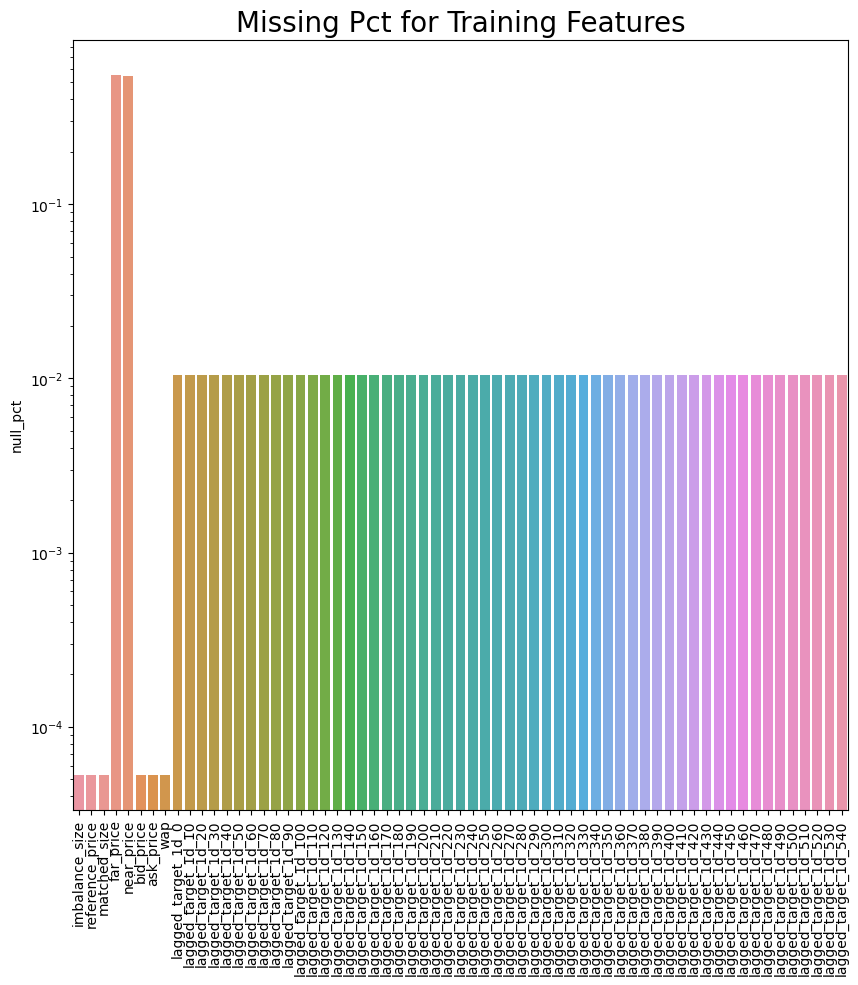

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plot_missing = X_other.isnull().mean().to_frame().rename(columns={0: 'null_pct'})
plot_missing = plot_missing[plot_missing.null_pct>0]
sns.barplot(plot_missing, x=plot_missing.index, y='null_pct', log=True)
plt.xticks(rotation=90)
plt.title('Missing Pct for Training Features', fontsize=20)
plt.savefig('../figures/EDA/missing_pct.png', dpi=300)

# Preprocessing
- Drop records with target missing (only a very small proportion of data)
- Manually construct new features & reduce memory
- Encoding & Scaling:
    - Categorical: imbalance_buy_sell_flag, stock_id --> One-Hot Encoding
    - All the remaining features are continuous: Standard Scaler
- Impute columns (except columns related to far / near price: use reduced feature method)

In [14]:
# drop records with target missing
df_other = df_other_splitted.dropna(subset=[target_col])
df_test = df_test_splitted.dropna(subset=[target_col])
print(df_other.shape, df_test.shape)

# Check missing pct
df_other_missing = df_other.isnull().mean().to_frame().rename(columns={0: 'null_pct'})
df_other_missing = df_other_missing[df_other_missing.null_pct>0].sort_values(by='null_pct')
df_test_missing = df_test.isnull().mean().to_frame().rename(columns={0: 'null_pct'})
df_test_missing = df_test_missing[df_test_missing.null_pct>0].sort_values(by='null_pct')
display(df_other_missing.T, df_test_missing.T)

(1034739, 72) (260040, 72)


,imbalance_size,reference_price,matched_size,bid_price,ask_price,wap,lagged_target_1d_380,lagged_target_1d_370,lagged_target_1d_360,lagged_target_1d_350,lagged_target_1d_340,lagged_target_1d_310,lagged_target_1d_320,lagged_target_1d_390,lagged_target_1d_300,lagged_target_1d_530,lagged_target_1d_330,lagged_target_1d_400,lagged_target_1d_420,lagged_target_1d_430,lagged_target_1d_440,lagged_target_1d_450,lagged_target_1d_460,lagged_target_1d_470,lagged_target_1d_480,lagged_target_1d_490,lagged_target_1d_500,lagged_target_1d_510,lagged_target_1d_520,lagged_target_1d_410,lagged_target_1d_270,lagged_target_1d_290,lagged_target_1d_280,lagged_target_1d_260,lagged_target_1d_230,lagged_target_1d_240,lagged_target_1d_0,lagged_target_1d_10,lagged_target_1d_20,lagged_target_1d_30,lagged_target_1d_40,lagged_target_1d_50,lagged_target_1d_60,lagged_target_1d_70,lagged_target_1d_80,lagged_target_1d_90,lagged_target_1d_250,lagged_target_1d_100,lagged_target_1d_120,lagged_target_1d_130,lagged_target_1d_140,lagged_target_1d_150,lagged_target_1d_160,lagged_target_1d_170,lagged_target_1d_180,lagged_target_1d_190,lagged_target_1d_200,lagged_target_1d_210,lagged_target_1d_220,lagged_target_1d_110,lagged_target_1d_540,near_price,far_price
null_pct,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.0105,0.5455,0.5532


,near_price,far_price
null_pct,0.5455,0.5525


In [15]:
# Prepare dataset, construct New Features & Reduce Memory
X_other = df_other.drop(columns=[target_col])
X_other = reduce_memory_usage(generate_all_features(X_other))
y_other = df_other[target_col]
groups_other = df_other[date_col]

print('\n')

X_test = df_test.drop(columns=[target_col])
X_test = reduce_memory_usage(generate_all_features(X_test))
y_test = df_test[target_col]
groups_test = df_test[date_col]

submission_id = df_test[identifier_cols]

# Print shape
print(X_other.shape, y_other.shape, groups_other.shape)
print(X_test.shape, y_test.shape, groups_test.shape)

Memory Usage Before Optimization:
821.0209350585938 MB

Memory Usage After Optimization:
398.66881942749023 MB


Memory Usage Before Optimization:
206.33056640625 MB

Memory Usage After Optimization:
100.18936157226562 MB
(1034739, 103) (1034739,) (1034739,)
(260040, 103) (260040,) (260040,)


In [16]:
# save cleaned dataset for future pipeline
import pickle

train_val_dataset = {'X_other': X_other,
                     'y_other': y_other,
                     'groups_other': groups_other}

test_dataset = {'X_test': X_test,
                'y_test': y_test,
                'groups_test': groups_test,
                'submission_id': submission_id}

with open('../data/preprocessed/train_val_dataset.pkl', 'wb') as file:
    pickle.dump(train_val_dataset, file)

with open('../data/preprocessed/test_dataset.pkl', 'wb') as file:
    pickle.dump(test_dataset, file)

In [17]:
print(X_other.columns.to_list())

['stock_id', 'seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap', 'lagged_target_1d_0', 'lagged_target_1d_10', 'lagged_target_1d_20', 'lagged_target_1d_30', 'lagged_target_1d_40', 'lagged_target_1d_50', 'lagged_target_1d_60', 'lagged_target_1d_70', 'lagged_target_1d_80', 'lagged_target_1d_90', 'lagged_target_1d_100', 'lagged_target_1d_110', 'lagged_target_1d_120', 'lagged_target_1d_130', 'lagged_target_1d_140', 'lagged_target_1d_150', 'lagged_target_1d_160', 'lagged_target_1d_170', 'lagged_target_1d_180', 'lagged_target_1d_190', 'lagged_target_1d_200', 'lagged_target_1d_210', 'lagged_target_1d_220', 'lagged_target_1d_230', 'lagged_target_1d_240', 'lagged_target_1d_250', 'lagged_target_1d_260', 'lagged_target_1d_270', 'lagged_target_1d_280', 'lagged_target_1d_290', 'lagged_target_1d_300', 'lagged_target_1d_310', 'lagged_target_1d_320', 'lagged_target_1d_330

In [18]:
import pickle
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

with open('../data/preprocessed/train_val_dataset.pkl', 'rb') as file:
    train_val_dataset = pickle.load(file)
    
with open('../data/preprocessed/test_dataset.pkl', 'rb') as file:
    test_dataset = pickle.load(file)

X_other, y_other, groups_other = train_val_dataset['X_other'], train_val_dataset['y_other'], train_val_dataset['groups_other']
X_test, y_test, groups_test, submission_id = test_dataset['X_test'], test_dataset['y_test'], test_dataset['groups_test'], test_dataset['submission_id']

# collect which encoder to use on each feature
onehot_ftrs = ['imbalance_buy_sell_flag', 'stock_id']
std_ftrs = ['seconds_in_bucket', 'imbalance_size', 'reference_price', 'matched_size', 
            'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 
            'wap', 'lagged_target_1d_0', 'lagged_target_1d_10', 'lagged_target_1d_20', 
            'lagged_target_1d_30', 'lagged_target_1d_40', 'lagged_target_1d_50', 
            'lagged_target_1d_60', 'lagged_target_1d_70', 'lagged_target_1d_80', 
            'lagged_target_1d_90', 'lagged_target_1d_100', 'lagged_target_1d_110', 
            'lagged_target_1d_120', 'lagged_target_1d_130', 'lagged_target_1d_140', 
            'lagged_target_1d_150', 'lagged_target_1d_160', 'lagged_target_1d_170', 
            'lagged_target_1d_180', 'lagged_target_1d_190', 'lagged_target_1d_200', 
            'lagged_target_1d_210', 'lagged_target_1d_220', 'lagged_target_1d_230', 
            'lagged_target_1d_240', 'lagged_target_1d_250', 'lagged_target_1d_260', 
            'lagged_target_1d_270', 'lagged_target_1d_280', 'lagged_target_1d_290', 
            'lagged_target_1d_300', 'lagged_target_1d_310', 'lagged_target_1d_320', 
            'lagged_target_1d_330', 'lagged_target_1d_340', 'lagged_target_1d_350', 
            'lagged_target_1d_360', 'lagged_target_1d_370', 'lagged_target_1d_380', 
            'lagged_target_1d_390', 'lagged_target_1d_400', 'lagged_target_1d_410', 
            'lagged_target_1d_420', 'lagged_target_1d_430', 'lagged_target_1d_440', 
            'lagged_target_1d_450', 'lagged_target_1d_460', 'lagged_target_1d_470', 
            'lagged_target_1d_480', 'lagged_target_1d_490', 'lagged_target_1d_500', 
            'lagged_target_1d_510', 'lagged_target_1d_520', 'lagged_target_1d_530', 
            'lagged_target_1d_540', 'volume', 'mid_price', 'liquidity_imbalance', 
            'matched_imbalance', 'size_imbalance', 'reference_price_far_price_imb', 
            'reference_price_near_price_imb', 'reference_price_ask_price_imb', 
            'reference_price_bid_price_imb', 'reference_price_wap_imb', 'far_price_near_price_imb', 
            'far_price_ask_price_imb', 'far_price_bid_price_imb', 'far_price_wap_imb', 
            'near_price_ask_price_imb', 'near_price_bid_price_imb', 'near_price_wap_imb', 
            'ask_price_bid_price_imb', 'ask_price_wap_imb', 'bid_price_wap_imb', 'price_spread', 
            'price_pressure', 'market_urgency', 'depth_pressure', 'all_prices_mean', 
            'all_sizes_mean', 'all_prices_std', 'all_sizes_std', 'all_prices_skew', 
            'all_sizes_skew', 'all_prices_kurt', 'all_sizes_kurt', 'dow', 'seconds', 'minute']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])

# Split train-validation data: cross validation applied later
len_group_other = groups_other.nunique()
gts = GroupTimeSeriesSplit(test_size=int(len_group_other*0.25), n_splits=1)
for i_train, i_val in gts.split(X_other, y_other, groups_other):
    print("Train index:", i_train, "Val index:", i_val)
    X_train, y_train, groups_train = X_other.iloc[i_train], y_other.iloc[i_train], groups_other.iloc[i_train]
    X_val, y_val, groups_val = X_other.iloc[i_val], y_other.iloc[i_val], groups_other.iloc[i_val]
    
# Fit and transform
X_train_prep = preprocessor.fit_transform(X_train)
feature_names = preprocessor.get_feature_names_out()
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

print(X_train_prep.shape)
print(X_train_prep)

Train index: [     0      1      2 ... 775521 775522 775523] Val index: [ 775524  775525  775526 ... 1034736 1034737 1034738]
(775524, 300)
[[ 0.          0.          1.         ... -1.3906883  -1.4230262
  -1.54715991]
 [ 1.          0.          0.         ... -1.3906883  -1.4230262
  -1.54715991]
 [ 1.          0.          0.         ... -1.3906883  -1.4230262
  -1.54715991]
 ...
 [ 0.          0.          1.         ...  0.02904178 -1.4230262
   1.85652971]
 [ 1.          0.          0.         ...  0.02904178 -1.4230262
   1.85652971]
 [ 1.          0.          0.         ...  0.02904178 -1.4230262
   1.85652971]]


In [19]:
preprocessor

ColumnTransformer(transformers=[('onehot',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['imbalance_buy_sell_flag', 'stock_id']),
                                ('std', StandardScaler(),
                                 ['seconds_in_bucket', 'imbalance_size',
                                  'reference_price', 'matched_size',
                                  'far_price', 'near_price', 'bid_price',
                                  'bid_size', 'ask_price', 'ask_size', 'wap',
                                  'lagged_target_1d_0', 'lagged_target_1...
                                  'lagged_target_1d_20', 'lagged_target_1d_30',
                                  'lagged_target_1d_40', 'lagged_target_1d_50',
                                  'lagged_target_1d_60', 'lagged_target_1d_70',
                                  'lagged_target_1d_80', 'lagged_target_1d_90',
                                  'lagged_target_1d_100',
                                  'lagged_target_1d_110',
                                  'lagged_target_1d_120',
                                  'lagged_target_1d_130',
                                  'lagged_target_1d_140',
                                  'lagged_target_1d_150',
                                  'lagged_target_1d_160',
                                  'lagged_target_1d_170',
                                  'lagged_target_1d_180', ...])])

In [20]:
feature_names

array(['onehot__imbalance_buy_sell_flag_-1',
       'onehot__imbalance_buy_sell_flag_0',
       'onehot__imbalance_buy_sell_flag_1', 'onehot__stock_id_0',
       'onehot__stock_id_1', 'onehot__stock_id_2', 'onehot__stock_id_3',
       'onehot__stock_id_4', 'onehot__stock_id_5', 'onehot__stock_id_6',
       'onehot__stock_id_7', 'onehot__stock_id_8', 'onehot__stock_id_9',
       'onehot__stock_id_10', 'onehot__stock_id_11',
       'onehot__stock_id_12', 'onehot__stock_id_13',
       'onehot__stock_id_14', 'onehot__stock_id_15',
       'onehot__stock_id_16', 'onehot__stock_id_17',
       'onehot__stock_id_18', 'onehot__stock_id_19',
       'onehot__stock_id_20', 'onehot__stock_id_21',
       'onehot__stock_id_22', 'onehot__stock_id_23',
       'onehot__stock_id_24', 'onehot__stock_id_25',
       'onehot__stock_id_26', 'onehot__stock_id_27',
       'onehot__stock_id_28', 'onehot__stock_id_29',
       'onehot__stock_id_30', 'onehot__stock_id_31',
       'onehot__stock_id_32', 'onehot__stoc

In [21]:
# check missing patterns
mask = pd.DataFrame(X_test_prep, columns=feature_names).isnull()
unique_rows, counts = np.unique(mask, axis=0, return_counts=True)
print(unique_rows.shape)
for i in range(len(counts)):
    print(unique_rows[i],counts[i])

(3, 300)
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False